 This notebook is intended to be a demonstration of a full machine-learning end-to-end pipeline on a HETDEX labelled dataset of approx. 36K spectra. 

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report

import xgboost as xgb

import torch
import torch.nn as nn
import os.path as op
from torch.utils.data import DataLoader, Dataset

The first step is to import the data, convert to a pandas dataframe and convert relevant datatypes. I note here that I have done some data preprocessing before loading the data. This included normalising the data sample-wise. Most ML pipelines will normalise the data feature-wise, but it was necessary to do it sample-wise in this case due to the diversity of the sample. Nearby sources have very high values of the flux, whereas distant sources will have low values generally, even though their astronomical type may be the same. We also divided each spectrum by its uncertainty to remove edge defects and other anomalies. Beyond that, we're ready to go.

In [39]:
dat = np.load('data/multiclass_fullset.npy', allow_pickle=True)
datdf = pd.DataFrame(dat[1:], columns=dat[0])
datdf.iloc[:,3:] = datdf.iloc[:,3:].astype('float')
datdf.shape

(35995, 1039)

We examine our data frame to see what it holds. We can see that there are two columns giving strings that identify each sample, detectid and shotid, one label column that encodes the classes of each sample spectrum, and 1036 columns that correspond to the spectrum. 

In [40]:
datdf.columns

Index(['detectid',   'shotid',    'label',          0,          1,          2,
                3,          4,          5,          6,
       ...
             1026,       1027,       1028,       1029,       1030,       1031,
             1032,       1033,       1034,       1035],
      dtype='object', length=1039)

Each spectrum belongs to one of four classes, badamp, badpix, meteor, and confirmed. The latter are the equivalent of good data, while the first two are bad data.

In [41]:
datdf.label.unique()

array(['badamp', 'badpix', 'meteor', 'confirmed'], dtype=object)

Let's inspect some of the spectra to see what we're dealing with here.

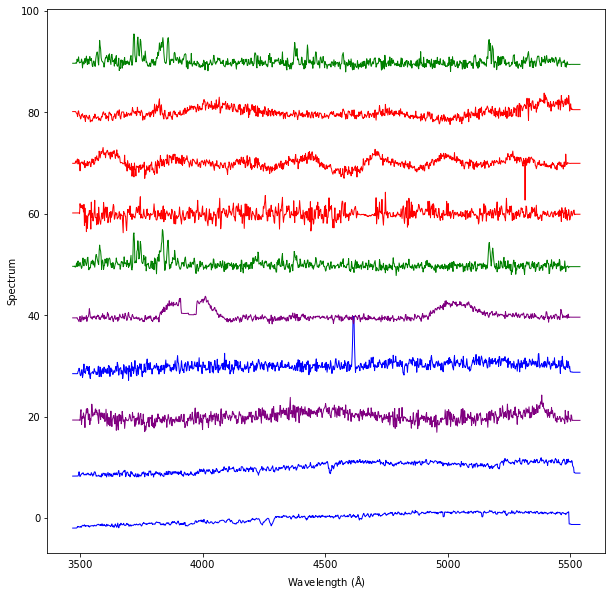

In [46]:
#index 10 random spectra from datdf
indicies = np.random.randint(datdf.shape[0], size=10)

#the wavelengths (x-axis) of these are constant across all sources, and equivalent to this:
wav = np.arange(3470, 5542, 2)

#make a colour look-up dict based on the labels
colour_dict = {'badamp':'red', 'badpix':'purple', 'meteor':'green', 'confirmed':'blue'}

plt.figure(figsize=(10,10))
for i, idx in enumerate(indicies):
    #select the spectrum from datdf
    spectrum = datdf.iloc[idx, 3:].astype('float')
    
    #plot the spectrum, adding a vertical shift to each spectrum for clarity.
    #the colour is set based on the class label of that spectrum
    plt.plot(wav, spectrum + i*10, color = colour_dict[datdf.label.iloc[idx]], lw = 1)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel('Spectrum')
plt.show()

We can see that there is a lot of diversity in the data set. Spectra have different continuum levels (the overall level of the line), broad dips (absorption features), small bumps (emission), large bumps (also emission) and other features. Luckily for us, classes do seem to share features in common with themselves. This is the data we are working with. It has 1036 dimensions in the raw data, and 36K samples. The next step will be to reduce the dimensionality of the data. But first, we will split it into train and test sets.


We split the data into train and test sets. 30% of the data is held out as a test set. This will later be used to evaluate our various machine learning model performances. We save the train and test sets for further use

In [32]:
train_tab, test_tab = train_test_split(datdf, test_size=.3, random_state=42, stratify=datdf.label)

train_tab.to_pickle('data/multiclass_train.pkl')
test_tab.to_pickle('data/multiclass_test.pkl')

The next step is to reduce the dimensionality of the dataset. To do this, we will use an autoencoder written in PyTorch. This is a lot of code. Essentially we are building a neural network that will learn to reproduce the input as the output. The power of this comes from the latent layer, a central bottleneck in the network architecture, which in this case will be a 100 dimensional representation of the 1036 dimensional data-set. 

Unfortunately it is not possible to run the autoencoder within this Jupyter notebook, as it requires a GPU to run efficiently. However, I include the underlying code at the end of this notebook for completeness and transparency.

**autoencoder here: see final three cells for code**

We have now defined our autoencoder, trained it on the training set, and generated encoded and decoded spectra for both train and test sets. We load this information in as a new array that was saved during the autoencoder phase. Our next step will be to inspect the decoded versions of the spectra to determine whether they give a sufficiently good representation of our original spectra.

In [47]:
testset = pd.read_pickle('data/multiclass_test.pkl')
outputs = pd.read_pickle('outputs/multiclass_test_outputs.pkl')

The next cell determines whether the original test set array rows match the rows of the autoencoder outputs. If the output is `True`, then the rows match. This is to ensure that we can index both with the same indicies and return the correct corresponding rows from each.

In [48]:
testset.reset_index(drop=True, inplace=True)
outputs.reset_index(drop=True, inplace=True)
np.all(outputs.detectid == testset.detectid)

True

We then grab the original spectra, and decoded versions, and randomly select N=10 of the data to plot.

In [51]:
test_spec_list = testset.iloc[:, 3:].to_numpy()
decoded_test_spec_list = outputs.iloc[:, -1036:].to_numpy()

#select N of the data for plotting
N = 10
inds = np.random.choice(range(len(testset)), size = N, replace=False)
testset_sample = testset.iloc[inds]
test_spec_list_sample = test_spec_list[inds]
decoded_test_spec_list_sample = decoded_test_spec_list[inds]

We then plot our randomly selected spectra, along with their decoded versions from the autoencoder.

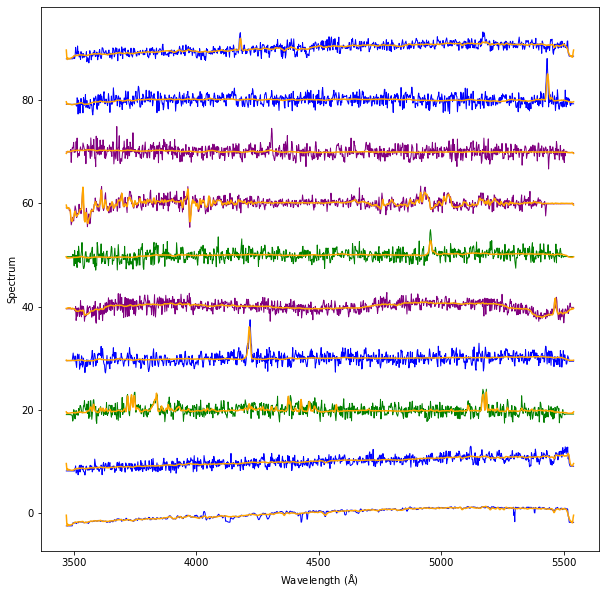

In [52]:
color = {'badamp':'red', 'badpix':'purple', 'meteor':'green', 'confirmed':'blue'}

wav = np.arange(3470, 5542, 2)
plt.figure(figsize=(10,10))
for idx in range(len(test_spec_list_sample)):
    plt.plot(wav, test_spec_list_sample[idx]+10*idx, lw=1, color=color[testset_sample.label.iloc[idx]])
    plt.plot(wav, decoded_test_spec_list_sample[idx]+10*idx, color='orange')
plt.ylabel('Spectrum')
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.show()

We can see that the autoencoder has done a decent job of representing our spectra in its decoded versions. Many of the features are represented, including the overall continuum level, the small bumps and dips in the spectra, and some more complex features. Another bonus of the autoencoder method is that it effectively ''denoises'' our data. We have to be careful here though, as sometimes we can lose informative features if they are interpreted as noise.

The next useful step we can do is some exploratory data analysis. It would be useful to know whether the four classes we have here are distinct and separable given some abstract space in which to represent them. The intuitive choice to answer this type of question is to use t-distributed stochastic neighbor embedding (t-SNE). This algorithm represents each spectrum in the data set as a single point in some high dimensional space, where that space has the same number of dimensions as the dimensions of our encoded spectra, namely 100. t-SNE then seeks to find a low dimensional space in which the pairwise similiarities of points, represented as proximity in the two spaces, is preserved. Let's get started.

We want to run t-SNE on the entire dataset, so we start by loading in the train and test datasets and concatenating them.

In [3]:
test_outputs = pd.read_pickle('outputs/multiclass_test_outputs.pkl')
train_outputs = pd.read_pickle('outputs/multiclass_train_outputs.pkl')
all_outputs = pd.concat([train_outputs, test_outputs], axis=0)

The primary hyperparameter of t-SNE is called the perplexity. The perplexity, loosely speaking, manages the balance between the local and global features of a dataset. In a sense, it represents the number of close neighbors each point has. It has been shown that a good rule of thumb for the perplexity is to set it to the square root of the number of samples in the dataset. We'll choose that approach here.

In [4]:
all_outputs.reset_index(inplace=True, drop=True)
perplexity = int(all_outputs.shape[0]**0.5)
print('Perplexity of sqrt(N) = ', perplexity)

Perplexity of sqrt(N) =  189


We set the latent dimensionality to 100, as before, and grab the encoded spectra from our autoencoder outputs array.

In [5]:
latent=100
encoded_arr = all_outputs.iloc[:,2:2+latent]

We initialize a t-SNE instance. We can use n_jobs=-1 to use all available cores.

In [6]:
tsne = TSNE(verbose=1, random_state=42, n_jobs=-1, perplexity = perplexity)

We then fit and transform our t-SNE instance to the data. This outputs a 2-dimensional space in which each spectrum is represented as a single point. This takes a few minutes.

In [7]:
embedded = tsne.fit_transform(encoded_arr)

[t-SNE] Computing 568 nearest neighbors...
[t-SNE] Indexed 35995 samples in 0.004s...
[t-SNE] Computed neighbors for 35995 samples in 34.583s...
[t-SNE] Computed conditional probabilities for sample 1000 / 35995
[t-SNE] Computed conditional probabilities for sample 2000 / 35995
[t-SNE] Computed conditional probabilities for sample 3000 / 35995
[t-SNE] Computed conditional probabilities for sample 4000 / 35995
[t-SNE] Computed conditional probabilities for sample 5000 / 35995
[t-SNE] Computed conditional probabilities for sample 6000 / 35995
[t-SNE] Computed conditional probabilities for sample 7000 / 35995
[t-SNE] Computed conditional probabilities for sample 8000 / 35995
[t-SNE] Computed conditional probabilities for sample 9000 / 35995
[t-SNE] Computed conditional probabilities for sample 10000 / 35995
[t-SNE] Computed conditional probabilities for sample 11000 / 35995
[t-SNE] Computed conditional probabilities for sample 12000 / 35995
[t-SNE] Computed conditional probabilities for s

We then extract our new t-SNE coordinates from the embedded array and add it as two new columns to our array of autoencoder outputs. This allows us to use seaborn to make a nice scatter plot of the result.

<AxesSubplot:xlabel='tsne_x', ylabel='tsne_y'>

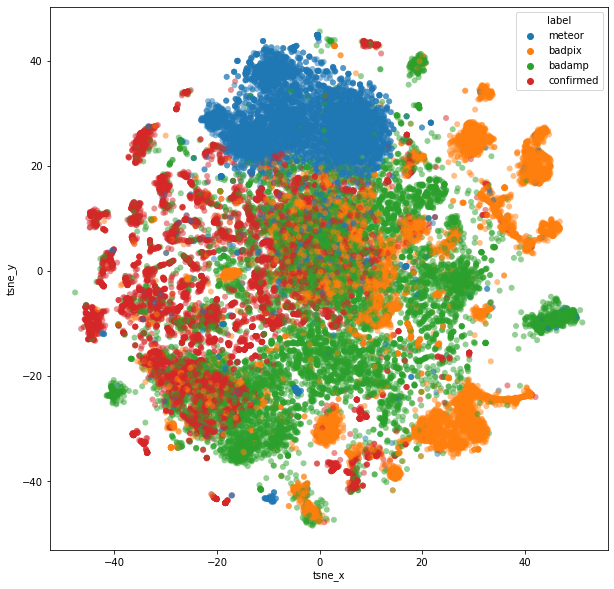

In [8]:
all_outputs['tsne_x'] = embedded[:,0]
all_outputs['tsne_y'] = embedded[:,1]

plt.figure(figsize=(10,10))
sns.scatterplot(data=all_outputs, x = 'tsne_x', y = 'tsne_y', hue='label', alpha=.5, linewidth=0)

There are a few things to take in about this visualisation. First, we see that the class of meteors is well separated from all other classes, making a blue blob at the top of the plot. That is encouraging. The other classes also exhibit some degree of separation, but we see that there is a large overlap region in the center of the plot that is populated primarily by badpix, badamps, and confirmed sources. This implies that it may be more difficult for a machine learning algorithm to distinguish those classes. This is a powerful exercise to gain some intuition about the problem that any subsequent machine learning is really trying to solve. However it is also important to note that this is a 2-dimensional representation of a 100-dimensional dataset, so it may be that some degree of additional separation is contained within the hidden dimensions.

The next step is to train our machine learning algorithm for classification of the classes. The aim of this project was to sort out the junk data from the good, so here we are going to encode our classes by grouping badamps and badpix together (as we don't care about distinguishing between these), while leaving the confirmed and meteor classes as they are. The machine learning algorithm we have chosen for this task is XGBoost. XGBoost is a bit like a random forest, in that it uses decision trees as its estimators. However, unlike a random forest these trees are trained sequentially, with each subsequent tree focussing on the samples that the previous trees got wrong. Each tree is then called a 'weak learner', and these weak learners combine to make one 'strong learner', an entity which outperforms most other machine learning algorithms for a variety of tasks in both accuracy and speed of training. Indeed, XGBoost is really taking the machine learning world by storm. Let's see what it can do for us.

First, load in our train and test sets.

In [ ]:
ae_outputs_train = pd.read_pickle('outputs/multiclass_train_outputs.pkl')
ae_outputs_test = pd.read_pickle('outputs/multiclass_test_outputs.pkl')


Extract the feature arrays from the train and test data frames.

In [13]:
latent = 100
trainX = ae_outputs_train.iloc[:,2:2+latent].astype('float')
testX = ae_outputs_test.iloc[:,2:2+latent].astype('float')

Now, define a label encoder. Our current labels are strings, so we want to encode them as integers. Badpix+badamps get a label of zero, meteors get a label of 1, and confirmed sources get a label of 2. We then run the new function `labelEncoder` to get the encoded labels.

In [3]:
def labelEncoder(labels):
        encoded = np.zeros((len(labels))).astype('int')
        encoded[labels == 'meteor'] = 1
        encoded[labels == 'confirmed'] = 2

        return encoded

In [4]:
trainy = labelEncoder(ae_outputs_train.label)
testy = labelEncoder(ae_outputs_test.label)

We need to optimize the hyperparameters of XGBoost such that we obtain the best results for our problem. The most important hyperparameters for XGBoost are the `max_depth`, that determines how deep the decision trees can be, and `n_estimators` that determines how many trees XGBoost will use in the forest. We define a grid over these parameters.

In [21]:
grid = {'n_estimators': [10, 50, 100, 500],
        'max_depth': [3, 6, 10, 20]
        }

We then instantiate our XGBoost classifier using an appropriate objective, or loss function, that is optimized during training.

In [22]:
classifier = xgb.XGBClassifier(n_jobs=4,
                        objective='multi:softmax',
                        verbosity=1,
                        tree_method='hist',
                        use_label_encoder=False
                        )

We then instantiate our grid search object from sklearn. The XGBoost library is handy as it is naturally integrated with sklearn functions. The `GridSearchCV` class also conducts cross-validation that helps to minimize the problem of over-fitting and ensures that our trained classifier will generalise well to unseen data.

In [23]:
clf_grid = GridSearchCV(classifier, grid, cv=4, verbose=2, n_jobs=-1)


We can then simply fit our grid search object to our training data. We are doing 4 'folds', i.e. cross-validation runs with differently sampled training and validation sets, and 16 points in the grid search, for a total of 64 fits of XGBoost to the data. This can take a few minutes.

In [24]:
clf_grid.fit(trainX, trainy)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [35]:
print(clf_grid.best_params_)
print(clf_grid.best_score_)
best_estimator = clf_grid.best_estimator_

{'max_depth': 10, 'n_estimators': 500}
0.904905540561994


We see that our best estimator from the grid search has a max_depth = 10 and n_estimators=500, returning a score of 90.5%. Let's do a little more to evaluate our best estimator. To get a good impression of the quality of our estimator, we should use data that it has not seen before to evaluate it. That's where our test set comes in. First, we use our estimator to make predictions on the test set classes.

In [36]:
predy = best_estimator.predict(testX)


Then, we use some built in sklearn libraries to evaluate its perfomance. The classification report provides many different metrics of success, including precision which is sensitive to false positives, and the recall which is sensitive to false negatives.

In [41]:
confusion_matrix = confusion_matrix(testy, predy)
classification_report = classification_report(testy, predy)

print(classification_report)


              precision    recall  f1-score   support

           0       0.90      0.93      0.92      5899
           1       0.99      0.91      0.95      2048
           2       0.86      0.85      0.85      2852

    accuracy                           0.91     10799
   macro avg       0.92      0.90      0.91     10799
weighted avg       0.91      0.91      0.91     10799



We can see that overall the algorithm did a good job of classifying our test set correctly. This is encouraging. It is most powerful on meteors with a precision of 99%. It appears to be more difficult to determine the bad and confirmed classes, which is consistent with what we saw in our earlier t-SNE plot. The team has since determined that this is because the original labels are not perfect, and some good sources have got a ''true'' label of bad.

To get a more detailed view of the classification of the test set, we can plot the confusion matrix. I use a custom function here with a seaborn heatmap, as I prefer the aesthetics to the default sklearn visualisation. The confusion matrix compares the true labels to the ML predicted labels for our entire test set. Correctly classified objects appear along the diagonal, while incorrectly classified samples are in the off-diagonal cells. 

Text(51.0, 0.5, 'True label')

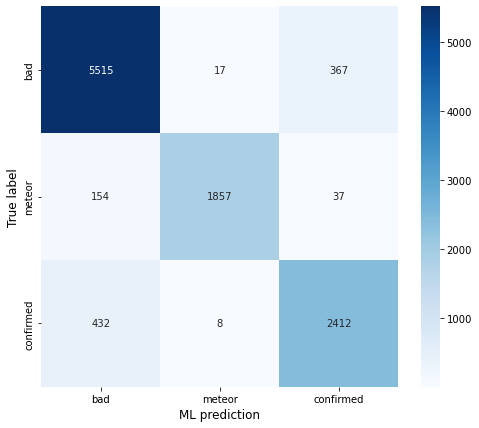

In [43]:
labels = ['bad', 'meteor', 'confirmed']
conf_df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
plt.figure(figsize=(8,7))
p = sns.heatmap(conf_df, annot=True, fmt='g', cmap='Blues')
p.set_xlabel('ML prediction', fontsize=12)
p.set_ylabel('True label', fontsize=12)

Again, we see that the meteors are by far the best performing class. This is so for two reasons, one because they have very distinct spectra, and two for reasons discussed above, that there may have been some confusion between labelling bad and confirmed sources correctly. Nonethless, this is a good result.

---------------------------------------------

_Appendix:_ here I have reproduced the code used to build, train and predict with the autoencoder in PyTorch. While these cells can't be run on my Jupyter notebook, I have run them on local dedicated GPU clusters as part of the overall pipeline. They are included here for completeness and transparency.

The key tasks are (1) building and defining our autoencoder architecture, as well as classes for loading in data and training the network, (2) training the network on both our train set (3) producing encoded and decoded representations of the spectra for both the train and test sets. These code for these tasks is given in the cells below.

This next cell will define our autoencoder architecture, as well as define several convenience classes to load in the data and train on it.

In [29]:

#run pytorch on gpu (change to 'cpu' otherwise)
device = 'cuda'

#torch module for data management
class SpecData(Dataset):
    def __init__(self, spectra, device):
        self.spectra = torch.tensor(spectra.astype(np.float32), device = device)
    def __getitem__(self, ind):
        return self.spectra[ind][None, :]
    def __len__(self):
        return self.spectra.size(0)

#custom module to flatten the convolutional channels for FC to latent
#and expand it on the other side into upsize channels
class View(nn.Module):
    def __init__(self, upsize = 0):
        super(View, self).__init__()
        self.upsize = upsize
    def forward(self, x):
        n_b = x.data.size(0)
        if self.upsize:
            return x.view(n_b, self.upsize, -1)
        else:
            return x.view(n_b, -1)
class Autoencoder(nn.Module):
        def __init__(self, latent):
            super(Autoencoder, self).__init__()
            self.re_leak = 0.1
            self.encode_seq = nn.Sequential(
                nn.Conv1d(1, 32, kernel_size=5, stride=2,padding=1),
                nn.LeakyReLU(self.re_leak),
                nn.Conv1d(32, 64, kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(self.re_leak),
                nn.Conv1d(64, 64, kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(self.re_leak),
                nn.Conv1d(64, 128, kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(self.re_leak),
                nn.Conv1d(128, 128, kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(self.re_leak),
                nn.Conv1d(128, 256, kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(self.re_leak),
                nn.Conv1d(256, 256, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(self.re_leak),
                nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(self.re_leak),
                View(),
                )
            self.dim_out = self.encode_seq(torch.ones(1,1,1036)).size(1)
            self.latent = latent

            self.linear_in_mu = nn.Linear(self.dim_out, self.latent)
            self.linear_in_logvar = nn.Linear(self.dim_out, self.latent)
            self.linear_out = nn.Linear(self.latent, self.dim_out)

            self.decode_seq = nn.Sequential(
                View(upsize = 512),
                nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(self.re_leak),
                nn.ConvTranspose1d(256, 256, kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(self.re_leak),
                nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(self.re_leak),
                nn.ConvTranspose1d(128, 128, kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(self.re_leak),
                nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(self.re_leak),
                nn.ConvTranspose1d(64, 64, kernel_size=4, stride=2,padding=0),
                nn.LeakyReLU(self.re_leak),
                nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(self.re_leak),
                nn.ConvTranspose1d(32, 1, kernel_size=4, stride=2,padding=1),
                nn.LeakyReLU(self.re_leak),
                nn.Conv1d(1,1,kernel_size=3,stride=1,padding=3)
                )

            self.N = torch.distributions.Normal(0, 1)
            self.N.loc = self.N.loc.cuda()
            self.N.scale = self.N.scale.cuda()
            self.kl = 0

        def encode(self, x):
            enc = self.encode_seq(x)
            latent = self.linear_in_mu(enc)
            return latent

        #decode numpy encoding, return numpy array
        def decode(self, x):
            code = torch.tensor(x.astype(np.float32), device='cuda')[None, None, :]
            to_decode = self.linear_out(code)
            dec = self.decode_seq(to_decode)
            dec = np.reshape(dec.detach().cpu().numpy(), 1036)
            return dec

        #forward pass that doesn't sample from the learned distribution, just uses mean
        def forward_mean(self, x):
            enc = self.encode_seq(x)
            mu = self.linear_in_mu(enc)
            z = mu
            to_decode = self.linear_out(z)
            dec = self.decode_seq(to_decode)
            return dec

        #normal forward pass for training, learns latent space distribution and samples from it
        def forward(self, x):
            enc = self.encode_seq(x)
            mu = self.linear_in_mu(enc)
            logvar = self.linear_in_logvar(enc)
            var = torch.exp(logvar)
            logsigma = 0.5*logvar
            sigma = torch.exp(logsigma)

            z = mu +sigma*self.N.sample(mu.shape)
            self.kl = torch.sum((0.5*var+0.5*mu**2 - logsigma - 0.5), 1)
            #average by batch size
            self.kl = torch.mean(self.kl)
            to_decode = self.linear_out(z)
            dec = self.decode_seq(to_decode)
            return dec
        #for epoch in epochs, perform gradient descent using train_load, and also calculate losses on validation
def train(model, optimizer, loss_fn, train_load, test_load, epochs, schedule, klweight):
    train_loss_list = []
    test_loss_list = []
    for i in range(epochs):
        avg_train_loss = 0.0
        for x in train_load:
            pred = model(x)
            #change loss function if running VAE (toggle flag)
            #if vae_flag == True:
            loss = torch.mean((x-pred)**2) + klweight*model.kl
            #else:
            #    loss = loss_fn(pred,x)
            avg_train_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        avg_train_loss /= len(train_load.dataset)
        train_loss_list.append(avg_train_loss.item())
        print('Epoch ', i, ' avg_train_loss: ', avg_train_loss.item())

        avg_test_loss = 0.0
        with torch.no_grad():
            for x in test_load:
                pred = model(x)
                loss = loss_fn(pred,x)
                avg_test_loss += loss
        avg_test_loss /= len(test_load.dataset)
        test_loss_list.append(avg_test_loss.item())
        print('Epoch ', i, ' avg_test_loss: ', avg_test_loss.item())
        schedule.step()
        print(optimizer.param_groups[0]['lr'])
    return train_loss_list, test_loss_list

Now that we have defined our autoencoder, the next step is to train it on our spectra. We do this for both the train and test sets as we will need both later. We then save the autoencoder as a .pth file. The best hyperparameters are chosen via the ''black magic of machine learning''; we essentially just twiddle the knobs until we find a set that work well.

In [ ]:
#already normalised by error
train_spec_list = train_tab.iloc[:,3:].to_numpy()
test_spec_list = test_tab.iloc[:,3:].to_numpy()

#store losses for each epoch during training
train_loss_list = []
test_loss_list = []
#for epoch in epochs, perform gradient descent using train_load, and also calculate losses on validation
# In[3]:

print('~~~initializing autoencoder~~~')
#hyperparameters
latent = 100
learning_rate = 0.0001
weight_decay = 0.0
lr_decay = 0.98
klweight = 0.002
batch = 30
loss_function = nn.MSELoss()

#torch data handling modules
train_loader = DataLoader(SpecData(train_spec_list, device = device),batch_size = batch, shuffle=True)
test_loader = DataLoader(SpecData(test_spec_list, device = device),batch_size = batch)

#initialize autoencoder (and load parameter state from saved model if desired)
ae = Autoencoder(latent = latent).to(device)
#ae.load_state_dict(torch.load('save/vae_8layer_10latent_diverr_100e.pth'))

#Adam has worked much better than standard SGD in my experience here
optimizer = torch.optim.Adam(ae.parameters(), lr = learning_rate, weight_decay = weight_decay)
#schedule a decrease in learning rate at each successive epoch
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)


# In[4]:

print('~~~training autoencoder~~~')
##train the model (comment out if loading from save to only run the analysis/classifier parts of this notebook)
epochs = 50
train_loss_list, test_loss_list = train(model = ae,
                                        optimizer = optimizer,
                                        loss_fn = loss_function,
                                        train_load = train_loader,
                                        test_load = test_loader,
                                        epochs = epochs,
                                        schedule = scheduler,
                                        klweight = klweight
                                        )


# In[5]:
print('~~~saving autoencoder~~~')

torch.save(ae.state_dict(), 'save/vae_8layer_100latent_multiclass.pth')

Now that we have our autoencoder trained, we can use it to generate encoded versions of our spectra, which we will need later for classification. We run this part on both the train and test sets by editing the loading and saving lines in the code. Statements with alive_bar, and bar() are used to conveniently generate a progress bar for the somewhat long for loops here. Again, unfortunately we can't run PyTorch functions here in the notebook as they need a GPU, but I put the code here for demonstrative purposes.

In [ ]:
print('~~~loading data~~~')

#change `train` to `test` to do the test set, too
all_tab = pd.read_pickle('data/multiclass_train.pkl')

all_tab.reset_index(drop=True, inplace=True)

all_spec_list = all_tab.iloc[:,3:].to_numpy()

print('~~~building autoencoder~~~')

latent=100

ae = Autoencoder(latent = latent).to(device)

ae.load_state_dict(torch.load('save/vae_8layer_100latent_multiclass.pth'))

print('~~~generating encoded spectra~~~')

all_code_outputs = []
with alive_bar(len(all_spec_list)) as bar:
        for i,x in enumerate(all_spec_list):
                spec = all_spec_list[i]
                encoded = ae.encode(torch.tensor(spec[None,None,:].astype(np.float32), device = device)).detach()
                encoded_np = np.reshape(encoded.cpu().numpy(), latent)
                all_code_outputs.append(encoded_np)
                bar()
all_code_arr = np.asarray(all_code_outputs)


print('~~~generating decoded spectra')
all_decoded = []
with alive_bar(len(all_code_arr)) as bar:
        for x in all_code_arr:
                decoded = ae.decode(x)
                all_decoded.append(decoded)
                bar()
all_maxvals = np.asarray(all_decode_maxvals)
decoded_all_spec_list = np.asarray(all_decoded)


print('~~~saving outputs~~~')
dcode_names = ['decoded_'+str(i) for i in range(1036)]
code_names = ['encoded_'+str(i) for i in range(latent)]

#this part makes arrays that contain the encoded and decoded spectra
all_code_df = pd.DataFrame(all_code_arr, columns=code_names)
all_dcode_df = pd.DataFrame(decoded_all_spec_list, columns=dcode_names)

all_sav = pd.concat([all_tab['detectid'], all_tab['label'], all_code_df, all_dcode_df], axis=1)
#again, change `train` to `test` to do the test set, too
all_sav.to_pickle('outputs/multiclass_train_outputs.pkl')

~~~loading data~~~
